# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,...,N$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$.

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Utilities

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

## Generate Toy Dataset

In [5]:
N = 1000
D = 3
T = 2

In [6]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, ln_tau):
    #z = np.random.randn(N) * np.exp(ln_tau)
    z = np.random.randn(N) * softplus(ln_tau)**(1/2.)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

In [7]:
# paramters
ln_tau = np.float64(4.)
#ln_tau = np.float64(0.7)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'ln_tau': ln_tau,
    'beta0': beta0,
    'beta': beta
}

In [8]:
x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [9]:
def sigmoid_normal_prob(x, beta0, beta, ln_tau):
    N, T, D  = x.shape
    #kappa = 1 / (1 + np.pi*tf.exp(ln_tau*2)/8)**(1/2)
    kappa = 1 / (1 + np.pi*tf.math.softplus(ln_tau)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [10]:
def sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, ln_tau)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [11]:
def laplace_approx(x, y, beta0, beta, ln_tau):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        #hessian = 1/np.exp(ln_tau*2) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        #grad    = z/np.exp(ln_tau*2) + np.sum( sig - y,     axis=1, keepdims=True)
        hessian = 1/softplus(ln_tau) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/softplus(ln_tau) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [12]:
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)

In [13]:
z.var(), (z-mu).var()

(4.077180659043433, 2.0246045072190673)

## IWELBO approximation of Evidence

In [14]:
def pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    #p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.exp(ln_tau))
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.math.softplus(ln_tau)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [15]:
def IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return iwelbo

In [16]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64).numpy()

In [17]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.3221548227263125, -1.2818780937712695, -1.2661132777588622)

## Maximum Likelihood by Different Approximation

In [18]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (100, 2, 3)

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0., dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    #ln_tau_   = tf.Variable(0., dtype=tf.float64)
    ln_tau_   = tf.Variable(1., dtype=tf.float64)
    
    # Gradient Descent
    for t in range(2001):
        
        rho_t = 0.5/(1+t)**0.7
        x,y,_ = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, ln_tau_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
            score = obj_func(beta0_, beta_, ln_tau_, mu, sigma)
        dbeta0_, dbeta_, dln_tau_ = g.gradient(score, [beta0_, beta_, ln_tau_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        ln_tau_ = ln_tau_ + dln_tau_
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198906
#iter: 200,	loss: 1.348260260354077
#iter: 400,	loss: 1.3375439744455444
#iter: 600,	loss: 1.3267028935774874
#iter: 800,	loss: 1.337053857990809
#iter: 1000,	loss: 1.3332193870716715
#iter: 1200,	loss: 1.3347526674168866
#iter: 1400,	loss: 1.3355521880592813
#iter: 1600,	loss: 1.3171721085315395
#iter: 1800,	loss: 1.3230176392480766
#iter: 2000,	loss: 1.3358715017989748

training elbo...
#iter: 0,	loss: 1.3242489370505066
#iter: 200,	loss: 1.2750979001323135
#iter: 400,	loss: 1.2900663619358517
#iter: 600,	loss: 1.283265503447246
#iter: 800,	loss: 1.2865463536568027
#iter: 1000,	loss: 1.274465660258819
#iter: 1200,	loss: 1.2699327526234039
#iter: 1400,	loss: 1.280854789335008
#iter: 1600,	loss: 1.2796372191945666
#iter: 1800,	loss: 1.2667295121506847
#iter: 2000,	loss: 1.2695788820610137

training iwelbo8...
#iter: 0,	loss: 1.3322687264803108
#iter: 200,	loss: 1.2794831747693625
#iter: 400,	loss: 1.2468005920801133
#iter: 600,	los

In [19]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [20]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,ln_tau,beta0,beta1,beta2,beta3
ground_truth,4.000000,0.000000,0.061249,0.461939,-0.643075
signorm,0.378514,0.001641,0.042315,0.329533,-0.457724
elbo,0.743640,-0.002171,0.045037,0.344039,-0.480620
iwelbo8,2.387775,0.001526,0.050559,0.394162,-0.547840
iwelbo64,3.402738,-0.001452,0.054671,0.413435,-0.573606
iwelbo512,3.661853,0.002176,0.057414,0.417788,-0.587914


##### Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation, even for simple this model. 

In [21]:
class AdamOptimizer:
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.ms_and_vs = 'uninitialized'
        self.t = 1
        
    def apply_gradients(self, grads, weights):
        
        if self.ms_and_vs == 'uninitialized':
            self.ms = [0 for _ in weights]
            self.vs = [0 for _ in weights]

        weights_new = []
        ms_new = []
        vs_new = []
        
        for g, w, m, v in zip(grads, weights, self.ms, self.vs):
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * np.power(g, 2)
            m_hat = m / (1 - np.power(self.beta1, self.t))
            v_hat = v / (1 - np.power(self.beta2, self.t))
            w.assign_sub( self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)  )
            
            ms_new.append(m)
            vs_new.append(v)
            weights_new.append(w)
            
        self.ms = ms_new
        self.vs = vs_new
        self.t += 1
        return weights_new

In [22]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = 1000 if tf.test.is_gpu_available() else 100, 2, 3

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)
    
    weights = [beta0_, beta_, ln_tau_]
    
    # Adam
    optimizer = AdamOptimizer(learning_rate=0.0003)

    for t in range(2001):
        
        x,y,_ = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch(weights)
            score = obj_func(*weights, mu, sigma)
            loss = - score
            
        grads = g.gradient(loss, weights)
        optimizer.apply_gradients(grads, weights)
        
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198906
#iter: 200,	loss: 1.3707171055212053
#iter: 400,	loss: 1.3528428944021367
#iter: 600,	loss: 1.3312023945811176
#iter: 800,	loss: 1.3410623693954145
#iter: 1000,	loss: 1.3426938914094133
#iter: 1200,	loss: 1.3206564826611966
#iter: 1400,	loss: 1.3081351819534204
#iter: 1600,	loss: 1.31484663602539
#iter: 1800,	loss: 1.3416456382312112
#iter: 2000,	loss: 1.3290410778918562

training elbo...
#iter: 0,	loss: 3.3410094907770027
#iter: 200,	loss: 3.023967484499803
#iter: 400,	loss: 3.177822596047671
#iter: 600,	loss: 2.7262216654215066
#iter: 800,	loss: 2.806871479394796
#iter: 1000,	loss: 2.6752930415700114
#iter: 1200,	loss: 2.631511068300235
#iter: 1400,	loss: 2.498154581635028
#iter: 1600,	loss: 2.4128848433718906
#iter: 1800,	loss: 2.4660048420646725
#iter: 2000,	loss: 2.3183719975211847

training iwelbo8...
#iter: 0,	loss: 1.5089649011984525
#iter: 200,	loss: 1.489869569915107
#iter: 400,	loss: 1.437779595235428
#iter: 600,	loss: 1

In [23]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,ln_tau,beta0,beta1,beta2,beta3
ground_truth,4.000000,0.000000,0.061249,0.461939,-0.643075
signorm,-0.448227,-0.000407,0.036280,0.306106,-0.436952
elbo,1.383611,0.000288,0.050738,0.425345,-0.592176
iwelbo8,0.620506,0.010779,0.047657,0.337367,-0.465715
iwelbo64,1.057014,0.002163,0.042973,0.353040,-0.495887
iwelbo512,1.383582,0.003989,0.040686,0.365589,-0.508970


#### Adam does not work well

## MLMC

In [24]:
def pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, ln_tau, mu, sigma)
    return scores

In [25]:
def dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return diwelbo

In [26]:
def IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    
    N, T, D = x.shape

    levels = np.arange(max_level)
    weights = 2.**(-(b+1)/2*levels)
    weights /= sum(weights)
    weights = np.concatenate([[w0], (1-w0)*weights])
    
    if randomize==True:
         Ns = np.random.multinomial(n=N, pvals=weights)
        
    elif randomize==False:
        Ns = np.zeros_like(levels)
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
                       
        if randomize==True:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l)
        
        N_offset += Ns[i]
    return score

In [27]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)    

In [28]:
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=6, w0=0.9, randomize=True)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2623518196950958>

In [29]:
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2644400108567964>

## MLMC codition check for objective

In [30]:
def conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [31]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)
L=10
conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

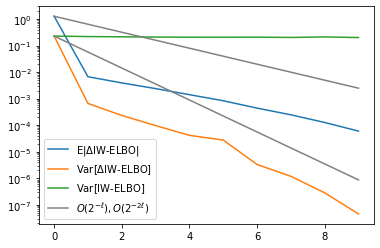

In [32]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[0]
plt.plot(s*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$',
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.yscale('log')

In [33]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.275703,1.277314,1.856386e+00,2.289688e-01,0.228969
1,0.006726,0.006726,7.071724e-04,6.619292e-04,0.219423
2,0.003940,0.003940,2.495505e-04,2.340271e-04,0.214770
3,0.002400,0.002400,1.029703e-04,9.720903e-05,0.209928
4,0.001419,0.001419,4.363170e-05,4.161684e-05,0.207385
5,0.000838,0.000838,2.844429e-05,2.774237e-05,0.206988
6,0.000442,0.000442,3.518712e-06,3.323145e-06,0.208311
7,0.000247,0.000247,1.256565e-06,1.195367e-06,0.203105
8,0.000127,0.000127,3.008163e-07,2.846336e-07,0.212216
9,0.000060,0.000060,4.929516e-08,4.567895e-08,0.201465


## MLMC codition check for gradients

In [34]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [ln_tau]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)        
    
    def get_grad(args):
        
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            ln_tau_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, ln_tau_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, ln_tau_, mu, sigma)
            
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        
        del g
        
        return a,b
    
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])
    grad_iwelbos = tf.squeeze(grads[1])
    
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [35]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)
L=10
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

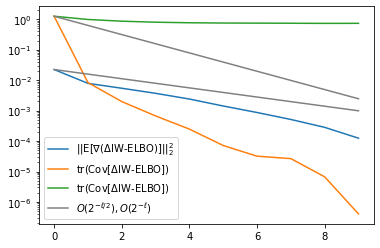

In [36]:
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[0]
plt.plot(s*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell})$'])
plt.yscale('log')

When we take gradient w.r.t. $\theta_1: \ \tau=\exp\theta_1$, $b\approx1$ for $V_\ell\propto 2^{-b\ell}$. 
<br>
However, taking gradient w.r.t. $\theta_2: \ \tau^2=:\mathrm{softplus}(\theta_2)$, we obtain $b\gtrapprox1$ for $V_\ell\propto 2^{-b\ell}$

In [37]:
conv_stats

,norm_mean_grad_dIWELBO,mean_norm_grad_dIWELBO,mean_squared_norm_grad_dIWELBO,trace_covariance_grad_dIWELBO,trace_covariance_grad_IWELBO
0,0.022289,0.927296,1.253767e+00,1.253270e+00,1.253270
1,0.007841,0.035868,8.364518e-03,8.303031e-03,0.981630
2,0.005413,0.019061,2.011843e-03,1.982546e-03,0.861689
3,0.003692,0.010910,6.810848e-04,6.674574e-04,0.798844
4,0.002394,0.006241,2.523368e-04,2.466035e-04,0.765758
5,0.001415,0.003440,7.337997e-05,7.137805e-05,0.749882
6,0.000866,0.001928,3.263249e-05,3.188279e-05,0.744045
7,0.000511,0.001088,2.675640e-05,2.649523e-05,0.738173
8,0.000282,0.000566,6.761692e-06,6.682248e-06,0.730432
9,0.000124,0.000258,4.204475e-07,4.050188e-07,0.733965


## Cost comparison of objective

In [38]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    NMC_ests.append( IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=2**9).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=False).numpy() )
    RandMLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=True).numpy() )

In [39]:
print("std-div of NMC estimator:      ", np.std(NMC_ests))
print("std-div of MLMC estimator:     ", np.std(MLMC_ests))
print("std-div of RandMLMC estimator: ", np.std(RandMLMC_ests))

std-div of NMC estimator:       0.0069707819566498744
std-div of MLMC estimator:      0.008807950550722157
std-div of RandMLMC estimator:  0.013472967429675764


In [40]:
%%timeit
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=2**9)

95 ms ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=False)

102 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=True)

84.3 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cost comparison of gradients

In [43]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    N0 = 2000
    x,y,_ = generate_data(N=N0, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    
    param = tf.concat([beta, [beta0], [ln_tau]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(param)
        beta_ = param[:D]
        beta0_ = param[D]
        ln_tau_ = param[D+1]
        nmc_est = IWELBO(x, y, beta0_, beta_, ln_tau_, mu, sigma, n_MC=2**12)
        mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1,  randomize=False)
        randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)
            
    nmc_est = g.gradient(nmc_est, param)
    mlmc_est = g.gradient(mlmc_est, param)
    randmlmc_est = g.gradient(randmlmc_est, param)
    
    del g
        
    NMC_ests.append( nmc_est )
    MLMC_ests.append( mlmc_est )
    RandMLMC_ests.append( randmlmc_est )

In [44]:
print("E||grad||^2 of NMC estimator:      ", np.mean(np.linalg.norm(NMC_ests)))
print("E||grad||^2 of MLMC estimator:     ", np.mean(np.linalg.norm(MLMC_ests)))
print("E||grad||^2 of RandMLMC estimator: ", np.mean(np.linalg.norm(RandMLMC_ests)))

E||grad||^2 of NMC estimator:       0.1826151595071211
E||grad||^2 of MLMC estimator:      0.30859350412882297
E||grad||^2 of RandMLMC estimator:  0.29205381966792004


In [45]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    nmc_est = IWELBO(x, y, beta0_, beta_, ln_tau_, mu, sigma, n_MC=2**12)

nmc_est = g.gradient(nmc_est, param)

483 ms ± 671 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=False)

mlmc_est = g.gradient(mlmc_est, param)

295 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)

randmlmc_est = g.gradient(randmlmc_est, param)

247 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### For finding nice configuration where MLMC wins NMC 

In [48]:
N,_ = y.shape
n_MC = 2
z = norm(loc=mu, scale=sigma).rvs([n_MC, N])

diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
score1 = np.var(NMC_ests) / diwelbos.mean()**2
score2 = np.var(MLMC_ests) / np.var(NMC_ests)
print(score1, score2)

print(np.std(x@beta, axis=1).mean(), z.std())

1.3948243166288943 2.856998954028648
0.45603794048099316 1.8214885064592938
